In [1]:
import tensorflow as tf
from keras.models import load_model
from ImageProcessing import *
from keras.models import model_from_json
from os import listdir
from collections import defaultdict 
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Input, ZeroPadding2D, Convolution2D, MaxPooling2D,\
Dropout, Flatten, Activation
from keras.models import Model, Sequential

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      print('here')
  except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

Physical devices cannot be modified after being initialized


In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
path_caDB_pairs = r"../Pairs_CADB/Pairs_CADB/"
path_calfw_text_file = r'../calfw/pairs_CALFW.txt'
path_calfw_images_dir = r'../calfw/aligned_images'
def CADB_image_getter(path): 
    images_file = listdir(path + '/')
    images_file.sort()
    positive_list = list()
    negative_list = list()
    anchor_list= list()
    for image in images_file: 
        id=int(image[:-6])
        use = int(image[-5])
        if 400<=id <600:
            if use==1:
                anchor_list.append(image)
            else: 
                positive_list.append(image)
        elif 600<=id<800:
            if use==1:
                negative_list.append(image)
        elif id>800:
            break
        else:
            continue
    return positive_list, anchor_list, negative_list



def Calf_image_getter(path):
    image_dict =defaultdict(list)
    positive_list = list()
    negative_list = list()
    anchor_list= list()
    with open(path, "r") as f: 
        Group = f.readlines()

    for aline in Group: 
        file = aline.split()[0]
        name = file.split("0")[0]
        group = int(aline.split()[1])
        if(group > 3):
            break
        else:
            image_dict[name].append(file)   
    keys = list(image_dict.keys())
    count = 0
    for index in range(len(keys)):
        image_list = image_dict[keys[index]]
        if len(image_list)>1:
            #get the first image of the dictionary key:
            anchor_list.append(image_list[0])
            positive_list.append(image_list[1])
            neg_index = np.random.randint(0, len(keys))
            negative_list.append(image_dict[keys[neg_index]][0])

            #get the second image of the dictionary key:
            anchor_list.append(image_list[1])
            positive_list.append(image_list[0])
            neg_index = np.random.randint(0, len(keys))
            negative_list.append(image_dict[keys[neg_index]][0])

        else:
            break
    return positive_list, anchor_list, negative_list




def get_test_image():
    path = "../Pairs_CADB/Pairs_CADB"
    images_file = listdir(path)
    images_file.sort()
    #positive:
    positive_list = list()
    anchor1 = list()
    #negative:
    anchor2 = list()
    negative_list = list()
    for image in images_file: 
        id=int(image[:-6])
        use = int(image[-5])
        if 400<= id <600:
            if use==1:
                anchor1.append(image)
            else: 
                positive_list.append(image)
        elif 600<=id<800:
            if use==1:
                negative_list.append(image)
            else:
                anchor2.append(image)
        elif id>800:
            break
        else:
            continue
    anchor_list = anchor1+ anchor2
    return positive_list, anchor_list, negative_list
    
    
    


In [29]:
positive_test, anchor_test, negative_test = get_test_image()

In [15]:
anchor, positive, negative = extract_images(r"../Pairs_CADB/Pairs_CADB", anchor_test, positive_test, negative_test, size=(224,224))


In [16]:
reference_test = anchor
query_test = np.concatenate([positive, negative], axis=0)
labels_test = np.concatenate([np.ones((positive.shape[0],)), np.zeros((negative.shape[0],))])
del anchor
del positive
del negative

In [18]:
query_test = face_detector(query_test)
reference_test = face_detector(reference_test)

0.0


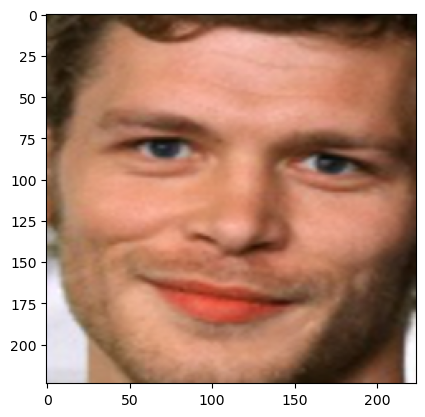

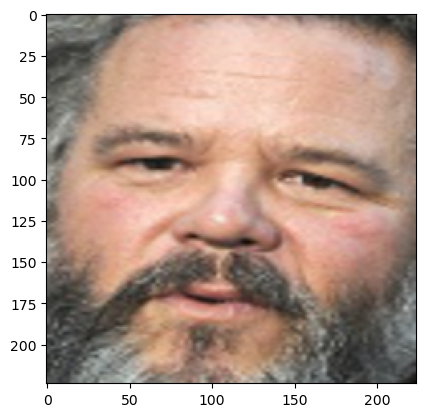

In [19]:
index = 201
print(labels_test[index])
plt.imshow(reference_test[index])
plt.show()
plt.imshow(query_test[index])
plt.show()

In [9]:
np.savez('siamise_test_set.npz', reference = reference_test, query=query_test, labels=labels_test)

# validation set: 

In [9]:
positive_list, anchor_list, negative_list =  CADB_image_getter(path_caDB_pairs)

In [10]:
anchor, positive, negative = extract_images(path_caDB_pairs, anchor_list, positive_list, negative_list, size=(224,224))
val_reference = np.concatenate([anchor, anchor], axis=0)
val_query = np.concatenate([positive, negative], axis=0)
val_labels = np.concatenate([np.ones((200,)), np.zeros((200,))])

permutation_index = np.random.permutation(len(val_labels))
val_reference = val_reference[permutation_index]
val_query = val_query[permutation_index]
val_labels = val_labels[permutation_index]
print(val_reference.shape)
print(val_query.shape)

(400, 224, 224, 3)
(400, 224, 224, 3)


In [11]:
val_reference = face_detector(val_reference)
val_query = face_detector(val_query)

# Training: 

In [16]:
positive_list, anchor_list, negative_list =  Calf_image_getter(path_calfw_text_file)

In [17]:
anchor, positive, negative = extract_images(path_calfw_images_dir, anchor_list, positive_list, negative_list, size=(224,224))
reference = np.concatenate([anchor, anchor], axis=0)
query = np.concatenate([positive, negative], axis=0)
labels = np.concatenate([np.ones((anchor.shape[0],)), np.zeros((anchor.shape[0],))])



In [19]:
reference = face_detector(reference)

/root/miniconda3/envs/dataScience/lib/python3.8/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/root/miniconda3/envs/dataScience/lib/python3.8/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/root/miniconda3/envs/dataScience/lib/python3.8/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/root/miniconda3/envs/dataScience/lib/python3.8/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


KeyboardInterrupt: 

In [ ]:
query = face_detector(query)

In [ ]:
permutation_index = np.random.permutation(labels.shape[0])
reference = reference[permutation_index]
query = query[permutation_index]
labels = labels[permutation_index]
print(reference.shape)
print(query.shape)
print(labels.shape)

(3460, 224, 224, 3)
(3460, 224, 224, 3)
(3460,)


In [ ]:
reference = np.concatenate([reference, val_reference[:300]])
query = np.concatenate([query, val_query[:300]])
labels = np.concatenate([labels, val_labels[:300]])
val_reference = val_reference[300:]
val_query = val_query[300:]
val_labels = val_labels[300:]

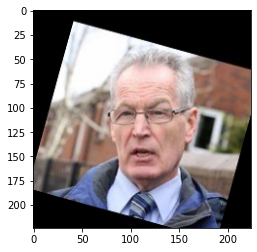

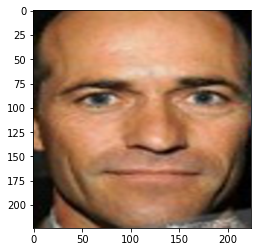

In [ ]:
index = 1364
plt.imshow(anchor[index])
plt.show()
plt.imshow(query[index])
plt.show()


In [34]:
print(reference.shape)
print(query.shape)
print(labels.shape)
print(val_reference.shape)
print(val_query.shape)
print(val_labels.shape)


(3760, 224, 224, 3)
(3760, 224, 224, 3)
(3760,)
(100, 224, 224, 3)
(100, 224, 224, 3)
(100,)


In [35]:
np.savez('siamise_training.npz', reference = reference, query=query, labels=labels)
np.savez('siamise_validation.npz', reference=val_reference, query=val_query, labels=val_labels)

In [50]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

ResourceExhaustedError: OOM when allocating tensor with shape[7,7,512,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: conv2d_206/random_uniform/mul/

In [ ]:
base_model = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
model.load_weights('/content/drive/MyDrive/Proyecto_IPI/vgg_face_weights.h5')

In [ ]:
def siamise_nn(X):
    query = X[0]
    reference = X[1]
    
    # add a global spatial average pooling layer
    D1 = Dense(1024, use_bias=False)
    D2 = Dense(1, activation='sigmoid')

    x_q = Input(query)
    x_r = Input(reference)

    X_q = base_model(x_q)
    X_q = GlobalAveragePooling2D()(X_q)
    # let's add a fully-connected layer
    X_q = D1(X_q)


    #reference: 
    X_r = base_model(x_r)
    X_r = GlobalAveragePooling2D()(X_r)
    # let's add a fully-connected layer
    X_r = D1(X_r)

    out = tf.abs(X_r- X_q)
    output = D2(out)

    # this is the model we will train
    model = Model(inputs=[x_q, x_r], outputs=output)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    return model

In [ ]:
model = siamise_nn([query.shape[1:], reference.shape[1:]])

In [ ]:
model.compile(optimizer='Adam', loss=keras.losses.BinaryCrossentropy())

In [ ]:
model.fit(x=[query, reference], y=labels, epochs=100)

In [ ]:
model.summary()

In [ ]:
testing = get_image('young_oprah.jpg')
testing = face_detector(testing)
ophra = np.expand_dims(anchor[2], axis=0)

In [ ]:
plt.imshow(testing[0])
plt.show()

In [ ]:
print(ophra.shape)

In [ ]:
model.predict([testing, ophra])